In [1]:
import itertools
import random

import altair as alt
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# reproducibility
rng = np.random.default_rng(seed=420)

 <b>!!! switch this, for switching between cases !!!</b>

In [3]:
case_switch = 'worst'
#case_switch = 'random'

# Create dataset

In [4]:
# globals
dataset_size = 1000
max_depths = list(range(1, 30))
params = {"max_depth": 5}
y_colname = "y"
init_x_colname = "cat"
noise_scale = 2

In [5]:
def gen_y_val_worstcase(key, noise_scale=noise_scale):
    rand = (rng.random(1) - 0.5) * noise_scale
    if key % 4 == 1:
        return 10 + rand[0]
    elif key % 3 == 2:
        return 20 + rand[0]
    else:
        return 1 + rand[0]

random_cat_dict = {} 

def gen_y_val_random(key, random_cat_dict=random_cat_dict, noise_scale=noise_scale):
    rand = (rng.random(1) - 0.5) * noise_scale
    return random_cat_dict[key] + rand[0]

## Worst case

In [6]:
categories = ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")
subcategories = ("1", "2", "3")

cat_vals_worst = ["".join(f) for f in itertools.product(categories, subcategories)]

In [7]:
print(f"There are {len(cat_vals_worst)} unique categories")
cat_vals_worst[:6]

There are 30 unique categories


['A1', 'A2', 'A3', 'B1', 'B2', 'B3']

In [8]:
df_worst = pd.DataFrame(index=range(dataset_size), columns=[init_x_colname, y_colname])
df_worst[init_x_colname] = [rng.choice(cat_vals_worst) for _ in range(dataset_size)]
df_worst[y_colname] = [gen_y_val_worstcase(int(f[1])) for f in df_worst[init_x_colname].tolist()]
df_worst.head()

,cat,y
0,G1,9.065550
1,H3,1.128245
2,B1,9.255394
3,J2,20.469195
4,I3,1.827283


## Random case

In [9]:
cat_vals_random = ("A", "B", "C", "D", "E", "F", "G", "H")
random_cat_dict = {key: rng.choice([1, 10, 20]) for key in cat_vals_random}

In [10]:
print(f"There are {len(cat_vals_random)} unique categories")
cat_vals_random[:6]

There are 8 unique categories


('A', 'B', 'C', 'D', 'E', 'F')

In [11]:
df_random = pd.DataFrame(index=range(dataset_size), columns=[init_x_colname, y_colname])
df_random[init_x_colname] = [rng.choice(cat_vals_random) for _ in range(dataset_size)]
df_random[y_colname] = [gen_y_val_random(f, random_cat_dict) for f in df_random[init_x_colname].tolist()]
df_random.head()

,cat,y
0,B,20.249585
1,H,0.652780
2,B,20.622270
3,H,0.555996
4,H,0.358285


# Train test split

- this is the first thing you do - do not even plot the test data according to Cassie Kozyrkov

In [12]:
df = None
def train_test_split_func(y_colname="y", df=df):
    retlist = train_test_split(
        df.drop(y_colname, axis=1).values,
        df[y_colname].values,
        test_size=0.2,
        random_state=42,
    )

    return [
        pd.DataFrame(f, columns=[f for f in df.columns if not f == y_colname])
        if i < 2
        else pd.DataFrame(f, columns=[y_colname])
        for i, f in enumerate(retlist)
    ]

In [13]:
if case_switch == 'random':
    df = df_random.copy()
elif case_switch.lower() == 'worst':
    df = df_worst.copy()
else:
    raise ValueError(f'Unknown case: {case_switch}. Choose one of `random` or `worst`.')

In [14]:
X_train, X_test, y_train, y_test = train_test_split_func(y_colname=y_colname, df=df)

# Check data

<AxesSubplot:xlabel='cat', ylabel='y'>

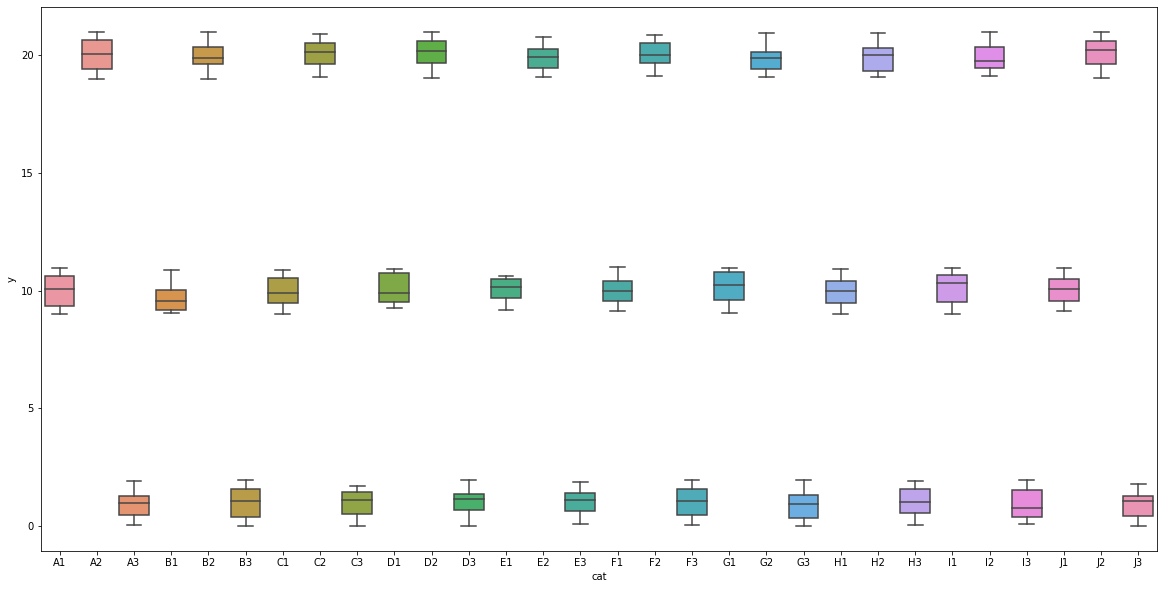

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=X_train.join(y_train).sort_values(by="cat"), x="cat", y="y")

# Functions

In [16]:
def dec_tree_rmse(
    params,
    x_colnames,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
):
    """
    Fit decision tree with params, and returns rmse and plot if plot.
    """
    dec_tree = DecisionTreeRegressor(**params).fit(X_train.loc[:, x_colnames], y_train)
    test_preds = dec_tree.predict(X_test.loc[:, x_colnames])
    rmse = mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

    source = pd.DataFrame(
        {"y": y_test["y"], "y_pred": test_preds, "cat": X_test["cat"]}
    )

    return rmse, source, dec_tree

def linreg_rmse(
    x_colnames,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
):
    """
    Fit decision tree with params, and returns rmse and plot if plot.
    """
    linreg = LinearRegression().fit(X_train.loc[:, x_colnames], y_train[y_colname])
    test_preds = linreg.predict(X_test.loc[:, x_colnames])
    rmse = mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

    source = pd.DataFrame(
        {"y": y_test["y"], "y_pred": test_preds, "cat": X_test["cat"]}
    )

    return rmse, source, linreg


def create_scatter(source):
    """
    Creates a scatterplot of true values and predictions colored by `cat` column.
    Colnames have to be `y` and `y_pred` respectively.
    """
    maxi_val = source[['y', 'y_pred']].max().max() + 2
    mini_val = source[['y', 'y_pred']].min().min() - 2
    return alt.Chart(source).mark_circle(
        size=60).encode(
        x=alt.X('y:Q', scale=alt.Scale(domain=(mini_val, maxi_val))),
        y=alt.Y("y_pred:Q", scale=alt.Scale(domain=(mini_val, maxi_val))), 
        color="cat", 
        tooltip="cat").properties(
        width=800, height=500).interactive()


def plot_max_depth_rmse(list_of_depths, list_of_rmse):
    """
    Creates a lineplot from 2 list of numeric values.
    """
    source = pd.DataFrame(index=range(len(list_of_rmse)), columns=["max_depth", "rmse"])
    source["rmse"] = list_of_rmse
    source["max_depth"] = list_of_depths
    return alt.Chart(source).mark_line().encode(x="max_depth", y="rmse").properties(
        width=800, height=500).interactive()


# https://mljar.com/blog/visualize-decision-tree/
def visualize_dec_tree(decision_tree):
    """
    Returns visualization of a decision tree
    """
    dot_data = tree.export_graphviz(
        decision_tree, out_file=None, feature_names=decision_tree.feature_names_in_, filled=True
    )
    return graphviz.Source(dot_data, format="png")

def create_encoded_column(encoder, colname_s, X_train=X_train, y_train=y_train):
    """
    Use encoder to fit_transform the `cat` column and insert the encoded column values
    to `x_colname` col in both train and test sets. Only fits on train, transforms test.
    """
    # you fit on training data
    X_train[colname_s] = encoder.fit_transform(X_train["cat"].values.reshape(-1, 1))

    # but only TRANSFORM the test data
    X_test[colname_s] = encoder.transform(X_test["cat"].values.reshape(-1, 1))
    
    return X_train, X_test

# Encodings

## Ordinal encoding

In [17]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

In [18]:
X_train.head()

,cat
0,B3
1,C3
2,D2
3,D1
4,I1


In [19]:
x_colnames_oe = 'ordinal_encoded'
X_train, X_test = create_encoded_column(oe, x_colnames_oe)

### Check one tree

In [20]:
rmse, source_oe, dec_tree = dec_tree_rmse(
    params=params, x_colnames=[x_colnames_oe]
)

In [21]:
rmse

6.607239167683132

In [22]:
create_scatter(source_oe)

alt.Chart(...)

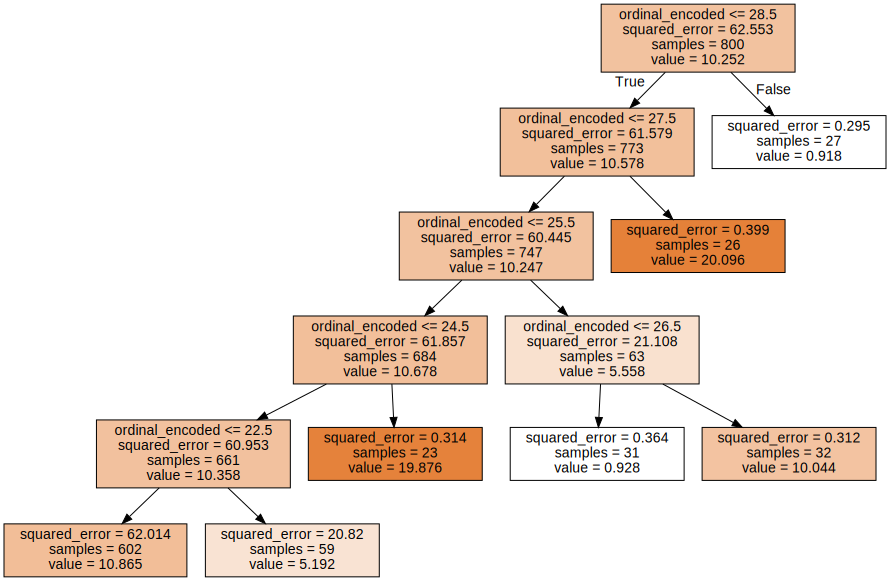

In [23]:
visualize_dec_tree(dec_tree)

#### Can we validate the plot?

In [24]:
colname = 'ordinal_encoded'
split_val = 28.5

y_train.loc[X_train[X_train[colname] <= split_val].index]['y'].mean()

10.577873475790813

In [25]:
def get_dec_tree_pred_simple(colname, split_val):
    return y_train.loc[X_train[X_train[colname] <= split_val].index]['y'].mean()

### Check tradeoff

In [26]:
rmses_oe = [dec_tree_rmse(params={"max_depth": i}, x_colnames=[x_colnames_oe])[0] for i in max_depths]

In [27]:
plot_max_depth_rmse(max_depths, rmses_oe)

alt.Chart(...)

## One-hot encoding

In [28]:
oh = OneHotEncoder(drop='first', sparse=False, dtype=np.int8)

In [29]:
X_train[oh.categories_[0][1:]] = oh.fit_transform(X_train['cat'].values.reshape(-1, 1))
x_colnames_oh = [str(f) for f in oh.categories_[0][1:]]

X_test[x_colnames_oh] = oh.transform(X_test['cat'].values.reshape(-1, 1))

### Check one tree

In [30]:
rmse_oh, source_oh, dec_tree_oh = dec_tree_rmse(
    params={"max_depth": 5}, x_colnames=x_colnames_oh
)

In [31]:
rmse_oh

5.957768157967098

In [32]:
create_scatter(source_oh)

alt.Chart(...)

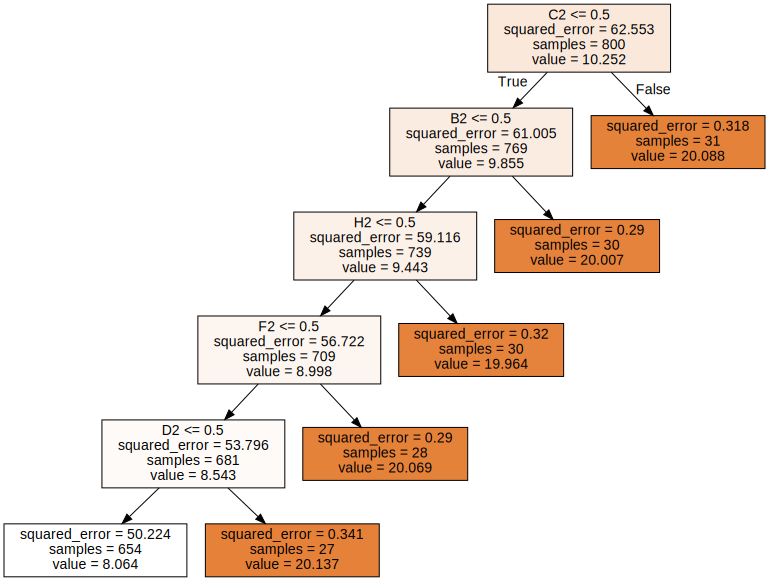

In [33]:
visualize_dec_tree(dec_tree_oh)

### Check tradeoff

In [34]:
rmses_oh = [dec_tree_rmse(params={"max_depth": i}, x_colnames=x_colnames_oh)[0] for i in max_depths]

In [35]:
plot_max_depth_rmse(max_depths, rmses_oh)

alt.Chart(...)

## Check together

In [36]:
rmse_oe = pd.DataFrame({'max_depth': max_depths, 'rmse': rmses_oe, 'origin': ['ordinal_encoded'] * len(max_depths)})
rmse_oh = pd.DataFrame({'max_depth': max_depths, 'rmse': rmses_oh, 'origin': ['onehot_encoded'] * len(max_depths)})
multi_rmse_source = pd.concat([rmse_oe, rmse_oh])

In [37]:
alt.Chart(multi_rmse_source).mark_line().encode(
    x='max_depth',
    y='rmse',
    color='origin'
)

alt.Chart(...)

## Hash encoding

In [38]:
fh_n_features = 10

x_colnames_fh = [f'fh{n}' for n in range(fh_n_features)]
fh = FeatureHasher(n_features=fh_n_features, input_type='string', dtype=np.float32)

In [39]:
fh_vec = fh.fit_transform(X=X_train['cat'])
fh_vec = pd.DataFrame(fh_vec.todense(), columns=x_colnames_fh, index=X_train.index)

fh_vec_test = fh.fit_transform(X=X_test['cat'])
fh_vec_test = pd.DataFrame(fh_vec_test.todense(), columns=x_colnames_fh, index=X_test.index)

X_train[x_colnames_fh] = fh_vec
X_test[x_colnames_fh] = fh_vec_test

### Check one tree

In [40]:
rmse_fh, source_fh, dec_tree_fh = dec_tree_rmse(params, x_colnames_fh)

In [41]:
create_scatter(source_fh)

alt.Chart(...)

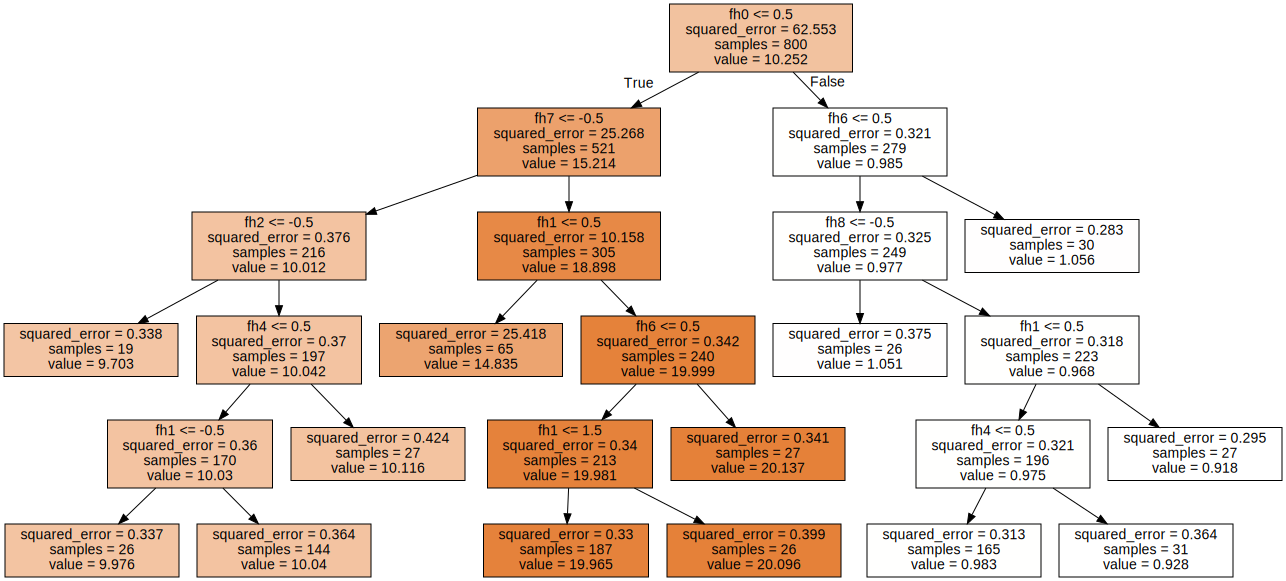

In [42]:
visualize_dec_tree(dec_tree_fh)

### Check tradeoff

In [43]:
rmses_fh = [dec_tree_rmse(params={"max_depth": i}, x_colnames=x_colnames_fh)[0] for i in max_depths]
plot_max_depth_rmse(max_depths, rmses_fh)

alt.Chart(...)

## Target encoding

In [44]:
from category_encoders.target_encoder import TargetEncoder

In [45]:
te = TargetEncoder(
    verbose=0,
    cols=[init_x_colname],
    drop_invariant=False,
    return_df=True,
    handle_missing='value',
    handle_unknown='value',
    min_samples_leaf=1,
    smoothing=1.0,)

In [46]:
x_colnames_te = 'target_encoded'
X_train[x_colnames_te] = te.fit_transform(X_train[init_x_colname], y_train)[init_x_colname]

In [47]:
X_test[x_colnames_te] = te.transform(X_test[init_x_colname], y_test)[init_x_colname]

In [48]:
rmse, source_oh, dec_tree = dec_tree_rmse(
    params={"max_depth": 5}, x_colnames=[x_colnames_te]
)

### Check one tree

In [49]:
rmse

0.5617423506033161

In [50]:
create_scatter(source_oh)

alt.Chart(...)

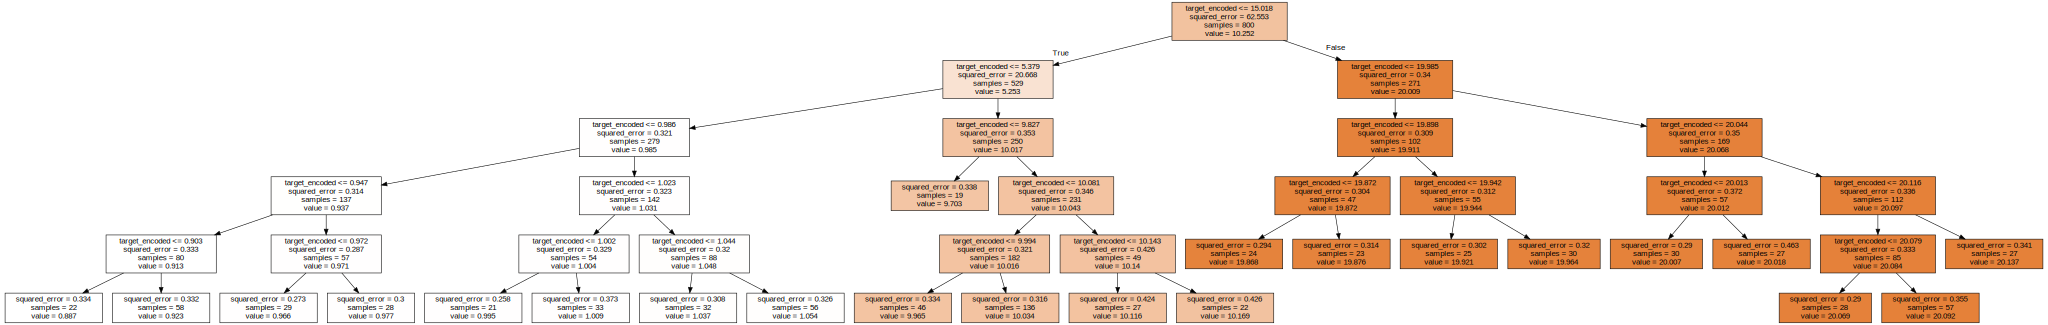

In [51]:
visualize_dec_tree(dec_tree)

### Check tradeoff

In [52]:
rmses_te = [dec_tree_rmse(params={"max_depth": i}, x_colnames=[x_colnames_te])[0] for i in max_depths]

In [53]:
plot_max_depth_rmse(max_depths, rmses_te)

alt.Chart(...)

## Check together

In [54]:
rmse_te = pd.DataFrame({'max_depth': max_depths, 'rmse': rmses_te, 'origin': ['target_encoded'] * len(max_depths)})
rmse_fh = pd.DataFrame({'max_depth': max_depths, 'rmse': rmses_fh, 'origin': ['hash_encoded'] * len(max_depths)})
multi_rmse_source = pd.concat([multi_rmse_source, rmse_te, rmse_fh])

In [55]:
alt.Chart(
    multi_rmse_source
).mark_line(
).encode(
    x='max_depth',
    y='rmse',
    color='origin',
    strokeWidth=alt.value(5)
).properties(
    width=800, 
    height=500
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    labelFontSize=20, 
    titleFontSize=20, 
    symbolStrokeWidth=5
).interactive()

alt.Chart(...)

# Linear Regression

## Ordinal encoded

In [56]:
rmse_linreg_oe, source_linreg_oe, linreg_oe = linreg_rmse(x_colnames=[x_colnames_oe])

In [57]:
rmse_linreg_oe

7.537811547535683

In [58]:
create_scatter(source_linreg_oe)

alt.Chart(...)

## Onehot encoded

In [59]:
rmse_linreg_oh, source_linreg_oh, linreg_oh = linreg_rmse(x_colnames=x_colnames_oh)

In [60]:
rmse_linreg_oh

0.5613899068648972

In [61]:
create_scatter(source_linreg_oh)

alt.Chart(...)

## Hash encoding

In [62]:
rmse_linreg_fh, source_linreg_fh, linreg_fh = linreg_rmse(x_colnames=x_colnames_fh)

In [63]:
rmse_linreg_fh

1.9862164772924344

In [64]:
create_scatter(source_linreg_fh)

alt.Chart(...)

## Target Encoded

In [65]:
rmse_linreg_te, source_linreg_te, linreg_te = linreg_rmse(x_colnames=[x_colnames_te])

In [66]:
rmse_linreg_te

0.5613899064995845

In [67]:
create_scatter(source_linreg_te)

alt.Chart(...)